In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import special
import matplotlib.pylab as plt
from __future__ import print_function, division # bring the print function and division of Python3 to 2.7


In the lab, we will have to probably truncate the data. Perhaps there are regions where the background is important, and we want to avoid it, or perhaps the feature we want to fit, like the guassian of the first photoelectron peak, is limited to a region. Slicing the data is very simple however limiting the fitting limits of a distribution forces a change in the normalization. The general formulation of a truncated distribution $f(x| \alpha < x < \beta)$ that comes from a distribution $f(x)$ if given by the following expresion:

$$f(x| \alpha < x < \beta) = \frac{f(x)}{F(\beta)-F(\alpha)}$$

Where $F(x)$ is the cummulative distribution of the density distribution $f(x)$. For an exponential, this formula can be calculated easily as there is an analytical solution. For the case of the normal distrubution, however, the cumulative is based on the error function.  

In [2]:
def exp_decay(x, A, t, y0):
    return A/t * np.exp(-x / t) + y0

def trun_exp(x, A, tau, y0, tmin, tmax):   
    return A *1./tau* 1./( (1 - np.exp(-tmax/tau)) - (1 - np.exp(-tmin/tau))) *  np.exp(-x / tau)


def gauss(x, mu, sigma, N):
    return N / np.sqrt(2*np.pi)/sigma * np.exp(-0.5*(x - mu)**2/sigma**2)

Let's calculate the cummulative distribution of a gaussian by making use of the erf function in scipy.

In [3]:
def F(x):
    return 1/2 * (1 + sp.special.erf(x/np.sqrt(2)))



In [4]:
def trun_gauss(x, mu, sigma, N, alpha, beta):
    return N / np.sqrt(2*np.pi)/sigma * np.exp(-0.5*(x - mu)**2/sigma**2)/(F((beta - mu)/sigma) - F((alpha - mu)/sigma))

Now let's try these truncated function. For that let's generate a Gaussian with the Hit&Miss method and then we are going to slice it.

In [5]:
mu_mc = 200
sigma_mc = 50
N = 1.

xmin = mu_mc - 5*sigma_mc
xmax = mu_mc + 5*sigma_mc
mc_events = 10000000

In [6]:
rnd1 = np.random.rand(mc_events)
rnd2 = np.random.rand(mc_events)
y = N*rnd1
x = xmin + (xmax - xmin)*rnd2
yprime = gauss(x, mu_mc, sigma_mc, N)

data = x[np.where(y < yprime)]

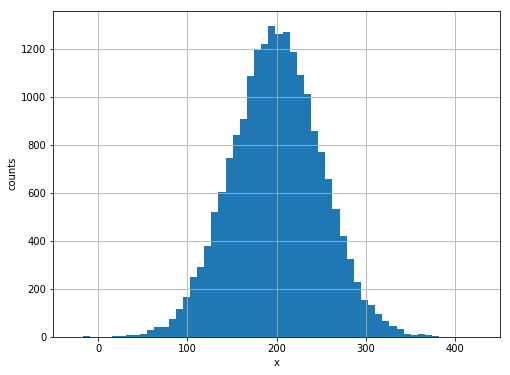

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
plt.grid()
hist, binsedges, patches = ax.hist(data,bins = 50, normed=False)
ax.set_xlabel("x")
ax.set_ylabel("counts")
ax.set_xlim(xmin, xmax)
plt.show()

Now let's slice the data. For that we are going to use even an assymetric slice

In [8]:
xmin = 170
xmax = 250
data_slice = data[(data > xmin)&(data < xmax)]

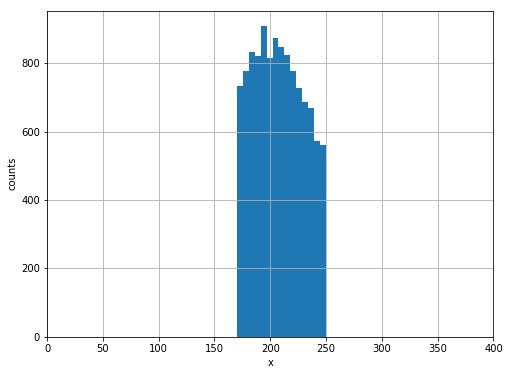

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
plt.grid()
hist, binsedges, patches = ax.hist(data_slice,bins = 15, normed=False)
ax.set_xlabel("x")
ax.set_ylabel("counts")
ax.set_xlim(0, 400)
plt.show()

We are going to fit in 2D using both a truncated Gaussian and a normal gaussian.

In [18]:
mumin = 180.
mumax = 220.

sigma_min = 35.
sigma_max = 55
mu_grid    = np.arange(mumin, mumax, 0.1)
sigma_grid = np.arange(sigma_min, sigma_max, 0.1)

tL = []
L = []

for m in mu_grid:
    L_m = []
    tL_m = []
    for s in sigma_grid:
        tP = trun_gauss(data_slice, m, s, 1., xmin, xmax)
        P = gauss(data_slice, m, s, 1.)
        
        #we put the logL calculated with both the truncated gaussian and a real gaussian
        tL_m.append(-np.sum(np.log(tP)))
        L_m.append(-np.sum(np.log(P)))

    L.append(L_m)
    tL.append(tL_m)
    
# a list of lists => a 2d array
L = np.array(L)
tL = np.array(tL)


In [11]:
i_best = np.where(L == L.min())
ti_best = np.where(tL == tL.min())

mu_best = mu_grid[i_best[0]]
sigma_best = sigma_grid[i_best[1]]


tmu_best = mu_grid[ti_best[0]]
tsigma_best = sigma_grid[ti_best[1]]

print ("Best fit results with the gaussian: ", mu_best, sigma_best)
print ("Best fit results with the truncated gaussian: ", tmu_best, tsigma_best)

Best fit results with the gaussian:  [207.9] [44.]
Best fit results with the truncated gaussian:  [199.6] [49.5]


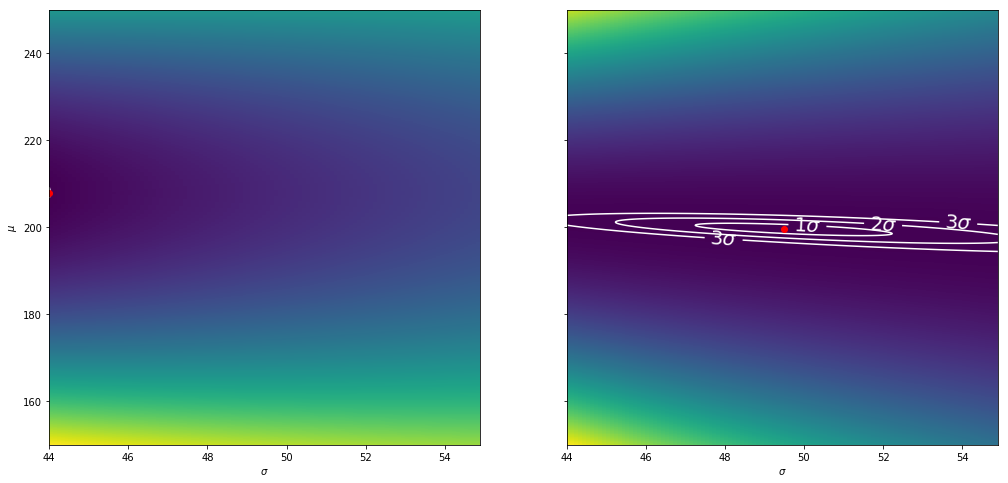

In [17]:
fig, axs = plt.subplots(1,2,sharey=True, figsize=(17,8))
mesh1 = axs[0].pcolormesh(sigma_grid, mu_grid, L)
mesh2 = axs[1].pcolormesh(sigma_grid, mu_grid, tL)

cs = axs[0].contour(sigma_grid, mu_grid, L, [L.min() + 0.5, L.min() + 4./2., L.min() + 9./2.],colors='white')
tcs = axs[1].contour(sigma_grid, mu_grid, tL, [tL.min() + 0.5, tL.min() + 4./2., tL.min() + 9./2.],colors='white')


fmt = {}
strs = ['1$\sigma$', '2$\sigma$', '3$\sigma$']
for l, s in zip(cs.levels, strs):
    fmt[l] = s
tfmt = {}
for l, s in zip(tcs.levels, strs):
    tfmt[l] = s

    
axs[0].clabel(cs, cs.levels, inline=1, fmt=fmt, fontsize=20)
axs[1].clabel(tcs, tcs.levels, inline=1, fmt=tfmt, fontsize=20)


axs[0].plot(sigma_best, mu_best, marker='o',color='r')
axs[1].plot(tsigma_best, tmu_best, marker='o',color='r')

axs[0].set_xlabel('$\sigma$')
axs[1].set_xlabel('$\sigma$')
axs[0].set_ylabel('$\mu$')
 

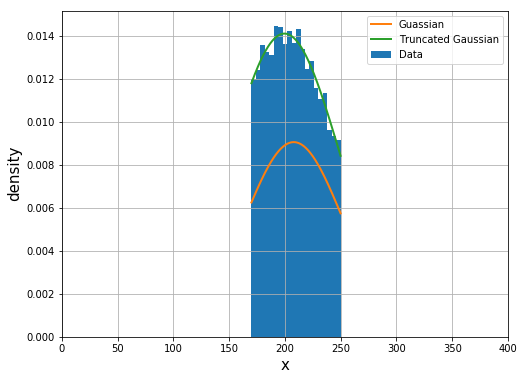

In [19]:
fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
ax2.hist(data_slice,bins = 20,normed=True, label="Data")
x = np.arange(xmin, xmax, 0.1)

# If the histogram is NOT normalized (normed = False) I need to rescale the PDF by the number of mc event and the binwidth
#  binwidth = np.diff(bins)[0]
ax2.plot(x, gauss(x, mu_best, sigma_best, 1.), lw =2 , label=r"Guassian")

ax2.plot(x, trun_gauss(x, tmu_best, tsigma_best, 1., xmin, xmax), lw =2 , label=r"Truncated Gaussian")
ax2.set_xlabel("x", fontsize=15)
ax2.set_ylabel("density", fontsize=15)
ax2.set_xlim(0, 400)
ax2.legend(loc="upper right")
plt.show()